# Libraries import

In [1]:
import warnings
from numba.core.errors import NumbaDeprecationWarning
warnings.filterwarnings('ignore',category=NumbaDeprecationWarning)

In [2]:
from SIReNet.epidemics_graph import EpidemicsGraph

# Graph initialization

In [3]:
!pwd

/home/mrcharles/SIReNet_project


In [4]:
city = EpidemicsGraph(pop_size=10000)
city.sampler_initializer()

In [5]:
city.create_families()

In [6]:
city.adjacency

<10000x10000 sparse matrix of type '<class 'numpy.bool_'>'
	with 18904 stored elements in Dictionary Of Keys format>

In [7]:
city.add_links(get_richer_step=1)

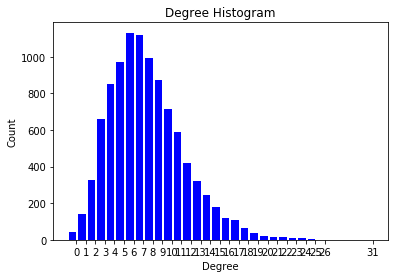

In [8]:
city.build_nx_graph()
city.degree_distribution()

In [9]:
city.components_dimension()[:10]

[9956, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [10]:
city.compute_common_neighbors()

<10000x10000 sparse matrix of type '<class 'numpy.int16'>'
	with 724808 stored elements in Dictionary Of Keys format>

# Dynamics

In [11]:
city.initialize_individual_factors()

In [12]:
city.start_infection(contagion_probability=0.05)

507 people have been infected


In [13]:
for i in range(50):
    city.propagate_infection(mu=2,time_resolution=1)

#city.propagation_stats()

-- EPIDEMICS --
Actual number of infect people: 3161
New Recovered: 0
New Deaths: 0
New Infects: 0.0


-- MODEL DYNAMICS --
- Scores
Min score: 0.0
Max score: 34.0
Mean score: 1.6086
Variance: 6.797285768576858
Skewness: 2.7888287047657343


15th percentile: 0.0
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 3.0
90th percentile: 5.0


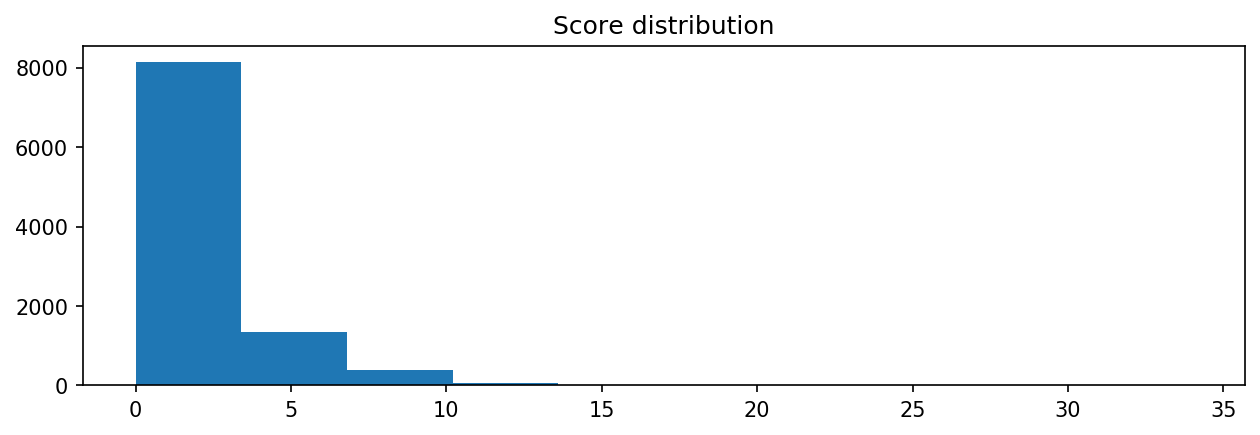



- Probs
Min score: 0.0
Max score: 1.0
Mean score: 0.2775223828215119
Variance: 0.1729106984860595
Skewness: 0.8888273386907326


15th percentile: 0.0
25th percentile: 0.0
50th percentile: 0.0
75th percentile: 0.6766764161830634
90th percentile: 0.9834363915193856


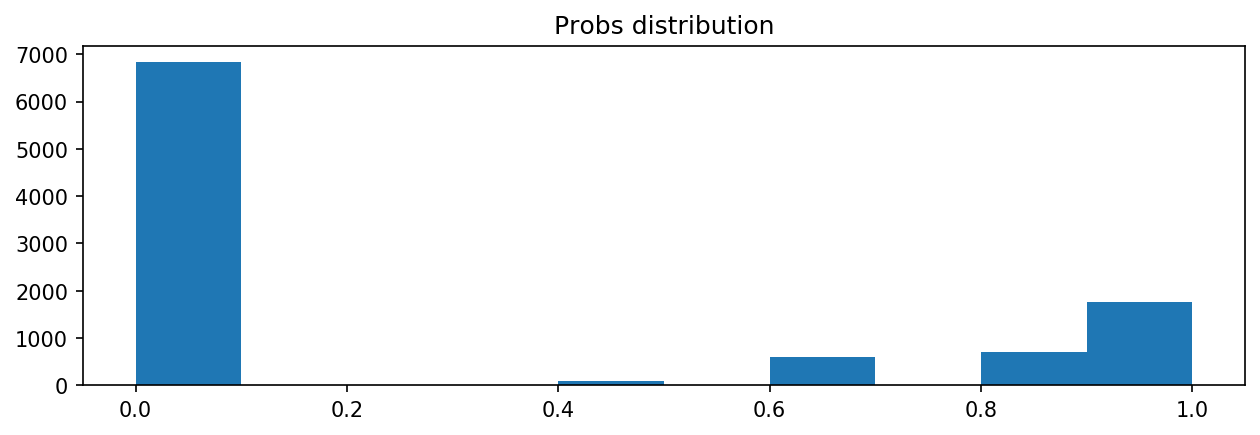

In [14]:
city.propagation_stats()

In [15]:
city.export_graph()

/home/mrcharles/SIReNet_project/adjacency.npz


In [16]:
city.infect_over_time

array([ 507.,  689., 1250., 2114., 2992., 3506., 3545., 3453., 3348.,
       3300., 3258., 3222., 3230., 3210., 3193., 3184., 3176., 3175.,
       3178., 3180., 3172., 3172., 3172., 3169., 3175., 3168., 3168.,
       3166., 3164., 3165., 3162., 3165., 3165., 3163., 3164., 3161.,
       3161., 3162., 3161., 3161., 3161., 3161., 3161., 3161., 3161.,
       3163., 3161., 3161., 3161., 3161., 3161.])

In [17]:
print(len(city.infect_over_time))
print(len(city.recovery_over_time))
print(len(city.death_over_time))

51
51
51


In [18]:
city.death_over_time

array([  0.,  67., 123., 183., 280., 272., 207., 120.,  75.,  34.,  13.,
         2.,   6.,   8.,   3.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,
         1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.])

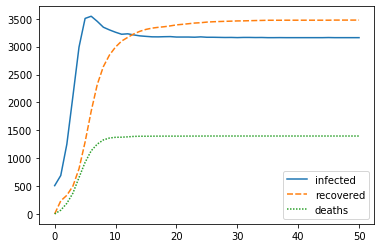

In [19]:
city.iterations_summary()

In [20]:
len(city.infect_probs_over_time)

50

In [21]:
from scipy import stats
import numpy as np


lower_quant = []
median = []
upper_quant = []

for i in range(50):
    
    prob_quantiles =np.percentile(city.infect_probs_over_time[i], [15, 25, 50, 75, 90])
    
    lower_quant.append(prob_quantiles[1])
    median.append(prob_quantiles[2])
    upper_quant.append(prob_quantiles[3])
    

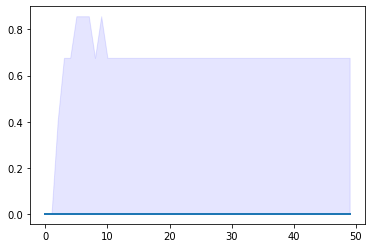

In [22]:
import matplotlib.pyplot as plt
plt.plot(median, linewidth=2)  # mean curve.
plt.fill_between(list(range(50)),lower_quant, upper_quant, color='b', alpha=.1)


# Neural net

In [23]:
import dgl
from dgl.data import RedditDataset
import torch as th

import numpy as np
import pandas as pd
import scipy.sparse as sp

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from SIReNet.utils import MaskSampler

from GraphSAGE.sampler import NeighborSampler
from GraphSAGE.models import SAGE
from GraphSAGE.utils import prepare_mp
from GraphSAGE.utils import compute_acc
from GraphSAGE.utils import evaluate
from GraphSAGE.utils import load_subtensor

from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import time

Using backend: pytorch


In [24]:
th.cuda.get_device_name()

'GeForce RTX 2070'

In [25]:
#fix seeds for reproducibility
np.random.seed(42)
th.manual_seed(42)
th.cuda.manual_seed(42)

In [26]:
features = pd.read_csv('node_features.csv')
indexes = features.index.values
labels = features['labels'].values

print(np.sum(labels)/labels.shape[0])

features = features.drop(['labels'],axis=1)
feature_transformer =  StandardScaler()
features = feature_transformer.fit_transform(features)

#FEATURES
features = th.FloatTensor(features)
in_feats = features.shape[1]

#LABELS
n_classes = len(np.unique(labels))
labels = th.LongTensor(labels)

#TRAINING, VALIDATION AND TESTING MATRICES
mask_sampler = MaskSampler(indexes)
train_mask, val_mask, test_mask = mask_sampler.sample(test_size=0.2,val_size=0.2)

0.6585884353741497


In [27]:
#GRAPH
adj = sp.load_npz('adjacency.npz')
g = dgl.DGLGraph()
g.from_scipy_sparse_matrix(adj)


g = dgl.graph(g.all_edges())
g.ndata['features'] = features
prepare_mp(g)
#tkipf normalizes the adjace matrix. Should we do the same here?

In [28]:
n_classes

2

## Model parameters

In [29]:
gpu = 0
num_epochs = 100
num_hidden = 16
num_layers = 2
fan_out = '10,25'
batch_size = 1000
log_every = 20
eval_every = 5
lr = 0.003
dropout = 0.5
num_workers = 0

In [30]:
device = th.device('cuda:0')

In [31]:
train_nid = th.LongTensor(np.nonzero(train_mask)[0])
val_mask = th.BoolTensor(val_mask)

## Model

In [32]:
sampler = NeighborSampler(g, [int(fanout) for fanout in fan_out.split(',')])

In [33]:
dataloader = DataLoader(
        dataset=train_nid.numpy(),
        batch_size=batch_size,
        collate_fn=sampler.sample_blocks,
        shuffle=True,
        drop_last=False,
        num_workers=num_workers)

In [34]:
model = SAGE(in_feats, num_hidden, n_classes, num_layers, F.relu, dropout)
model = model.to(device)
loss_fcn = nn.CrossEntropyLoss()
loss_fcn = loss_fcn.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [35]:
avg = 0
iter_tput = []
for epoch in range(num_epochs):
        tic = time.time()

        # Loop over the dataloader to sample the computation dependency graph as a list of
        # blocks.
        for step, blocks in enumerate(dataloader):
            tic_step = time.time()

            # The nodes for input lies at the LHS side of the first block.
            # The nodes for output lies at the RHS side of the last block.
            input_nodes = blocks[0].srcdata[dgl.NID]
            seeds = blocks[-1].dstdata[dgl.NID]

            # Load the input features as well as output labels
            batch_inputs, batch_labels = load_subtensor(g, labels, seeds, input_nodes, device)

            # Compute loss and prediction
            batch_pred = model(blocks, batch_inputs)
            loss = loss_fcn(batch_pred, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iter_tput.append(len(seeds) / (time.time() - tic_step))
            if step % log_every == 0:
                acc = compute_acc(batch_pred, batch_labels)
                gpu_mem_alloc = th.cuda.max_memory_allocated() / 1000000 if th.cuda.is_available() else 0
                print(
                    'Epoch {:05d} | Step {:05d} | Loss {:.4f} | Train Acc {:.4f} | Speed (samples/sec) {:.4f} | GPU {:.1f} MiB'.format(
                        epoch, step, loss.item(), acc.item(), np.mean(iter_tput[3:]), gpu_mem_alloc))

        toc = time.time()
        print('Epoch Time(s): {:.4f}'.format(toc - tic))
        if epoch >= 5:
            avg += toc - tic
        if epoch % eval_every == 0 and epoch != 0:
            eval_acc = evaluate(model, g, g.ndata['features'], labels, val_mask, batch_size, device)
            print('Eval Acc {:.4f}'.format(eval_acc))

print('Avg epoch time: {}'.format(avg / (epoch - 4)))

/home/mrcharles/anaconda3/envs/SIReNet/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/mrcharles/anaconda3/envs/SIReNet/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Step 00000 | Loss 1.7309 | Train Acc 0.4660 | Speed (samples/sec) nan | GPU 0.9 MiB
Epoch Time(s): 0.4309
Epoch 00001 | Step 00000 | Loss 1.4658 | Train Acc 0.4860 | Speed (samples/sec) 115475.0976 | GPU 1.0 MiB
Epoch Time(s): 0.0363
Epoch 00002 | Step 00000 | Loss 1.5049 | Train Acc 0.4560 | Speed (samples/sec) 153513.3863 | GPU 1.0 MiB
Epoch Time(s): 0.0364
Epoch 00003 | Step 00000 | Loss 1.2576 | Train Acc 0.4410 | Speed (samples/sec) 159544.2014 | GPU 1.0 MiB
Epoch Time(s): 0.0360
Epoch 00004 | Step 00000 | Loss 1.3618 | Train Acc 0.4400 | Speed (samples/sec) 162681.0013 | GPU 1.0 MiB
Epoch Time(s): 0.0359
Epoch 00005 | Step 00000 | Loss 1.1625 | Train Acc 0.4790 | Speed (samples/sec) 164867.2517 | GPU 1.0 MiB


100%|██████████| 5/5 [00:00<00:00, 425.88it/s]

Epoch Time(s): 0.0372
Eval Acc 0.4489
Epoch 00006 | Step 00000 | Loss 1.0801 | Train Acc 0.4900 | Speed (samples/sec) 166163.3714 | GPU 1.0 MiB
Epoch Time(s): 0.0355
Epoch 00007 | Step 00000 | Loss 1.0108 | Train Acc 0.5290 | Speed (samples/sec) 167374.0009 | GPU 1.0 MiB
Epoch Time(s): 0.0359
Epoch 00008 | Step 00000 | Loss 1.0758 | Train Acc 0.5270 | Speed (samples/sec) 168004.4828 | GPU 1.0 MiB
Epoch Time(s): 0.0361
Epoch 00009 | Step 00000 | Loss 0.8914 | Train Acc 0.5890 | Speed (samples/sec) 168627.2719 | GPU 1.0 MiB
Epoch Time(s): 0.0353
Epoch 00010 | Step 00000 | Loss 0.8830 | Train Acc 0.6280 | Speed (samples/sec) 169163.9857 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 423.86it/s]

Epoch Time(s): 0.0369
Eval Acc 0.6733
Epoch 00011 | Step 00000 | Loss 0.8755 | Train Acc 0.6460 | Speed (samples/sec) 169470.3262 | GPU 1.0 MiB
Epoch Time(s): 0.0355
Epoch 00012 | Step 00000 | Loss 0.7755 | Train Acc 0.6450 | Speed (samples/sec) 169865.7302 | GPU 1.0 MiB
Epoch Time(s): 0.0357
Epoch 00013 | Step 00000 | Loss 0.7471 | Train Acc 0.6830 | Speed (samples/sec) 170105.7831 | GPU 1.0 MiB
Epoch Time(s): 0.0356
Epoch 00014 | Step 00000 | Loss 0.7063 | Train Acc 0.6760 | Speed (samples/sec) 170289.3130 | GPU 1.0 MiB
Epoch Time(s): 0.0354
Epoch 00015 | Step 00000 | Loss 0.6439 | Train Acc 0.7150 | Speed (samples/sec) 170629.6519 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 361.48it/s]

Epoch Time(s): 0.0370
Eval Acc 0.7902
Epoch 00016 | Step 00000 | Loss 0.6354 | Train Acc 0.7040 | Speed (samples/sec) 170249.0599 | GPU 1.0 MiB
Epoch Time(s): 0.0404
Epoch 00017 | Step 00000 | Loss 0.5901 | Train Acc 0.7380 | Speed (samples/sec) 170029.4873 | GPU 1.0 MiB
Epoch Time(s): 0.0352
Epoch 00018 | Step 00000 | Loss 0.5640 | Train Acc 0.7520 | Speed (samples/sec) 170319.5749 | GPU 1.0 MiB
Epoch Time(s): 0.0353
Epoch 00019 | Step 00000 | Loss 0.5427 | Train Acc 0.7520 | Speed (samples/sec) 170592.8629 | GPU 1.0 MiB
Epoch Time(s): 0.0353
Epoch 00020 | Step 00000 | Loss 0.5062 | Train Acc 0.7790 | Speed (samples/sec) 170890.7044 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 427.16it/s]

Epoch Time(s): 0.0365
Eval Acc 0.8486
Epoch 00021 | Step 00000 | Loss 0.5026 | Train Acc 0.7750 | Speed (samples/sec) 170578.3780 | GPU 1.0 MiB
Epoch Time(s): 0.0354
Epoch 00022 | Step 00000 | Loss 0.4910 | Train Acc 0.7840 | Speed (samples/sec) 170858.3797 | GPU 1.0 MiB
Epoch Time(s): 0.0359
Epoch 00023 | Step 00000 | Loss 0.4507 | Train Acc 0.7930 | Speed (samples/sec) 170781.1729 | GPU 1.0 MiB
Epoch Time(s): 0.0350
Epoch 00024 | Step 00000 | Loss 0.4800 | Train Acc 0.7750 | Speed (samples/sec) 171127.9277 | GPU 1.0 MiB
Epoch Time(s): 0.0350
Epoch 00025 | Step 00000 | Loss 0.4204 | Train Acc 0.8140 | Speed (samples/sec) 171462.1167 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 425.83it/s]

Epoch Time(s): 0.0358
Eval Acc 0.8712
Epoch 00026 | Step 00000 | Loss 0.4324 | Train Acc 0.7880 | Speed (samples/sec) 171634.2748 | GPU 1.0 MiB
Epoch Time(s): 0.0354
Epoch 00027 | Step 00000 | Loss 0.4222 | Train Acc 0.8190 | Speed (samples/sec) 171749.9313 | GPU 1.0 MiB
Epoch Time(s): 0.0354
Epoch 00028 | Step 00000 | Loss 0.4155 | Train Acc 0.8100 | Speed (samples/sec) 171775.3645 | GPU 1.0 MiB
Epoch Time(s): 0.0356
Epoch 00029 | Step 00000 | Loss 0.3889 | Train Acc 0.8280 | Speed (samples/sec) 171843.4153 | GPU 1.0 MiB
Epoch Time(s): 0.0357
Epoch 00030 | Step 00000 | Loss 0.3866 | Train Acc 0.8370 | Speed (samples/sec) 171937.2109 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 427.20it/s]

Epoch Time(s): 0.0365
Eval Acc 0.8858
Epoch 00031 | Step 00000 | Loss 0.3518 | Train Acc 0.8610 | Speed (samples/sec) 172025.4039 | GPU 1.0 MiB
Epoch Time(s): 0.0355
Epoch 00032 | Step 00000 | Loss 0.3779 | Train Acc 0.8410 | Speed (samples/sec) 172131.9581 | GPU 1.0 MiB
Epoch Time(s): 0.0355
Epoch 00033 | Step 00000 | Loss 0.3848 | Train Acc 0.8360 | Speed (samples/sec) 172136.8905 | GPU 1.0 MiB
Epoch Time(s): 0.0356
Epoch 00034 | Step 00000 | Loss 0.3709 | Train Acc 0.8340 | Speed (samples/sec) 172186.8064 | GPU 1.0 MiB
Epoch Time(s): 0.0404
Epoch 00035 | Step 00000 | Loss 0.3358 | Train Acc 0.8610 | Speed (samples/sec) 171705.9172 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 426.74it/s]

Epoch Time(s): 0.0421
Eval Acc 0.9070
Epoch 00036 | Step 00000 | Loss 0.3779 | Train Acc 0.8310 | Speed (samples/sec) 171295.2717 | GPU 1.0 MiB
Epoch Time(s): 0.0404
Epoch 00037 | Step 00000 | Loss 0.3747 | Train Acc 0.8350 | Speed (samples/sec) 170873.2543 | GPU 1.0 MiB
Epoch Time(s): 0.0415
Epoch 00038 | Step 00000 | Loss 0.3569 | Train Acc 0.8450 | Speed (samples/sec) 170566.3862 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Epoch 00039 | Step 00000 | Loss 0.3575 | Train Acc 0.8580 | Speed (samples/sec) 170179.1896 | GPU 1.0 MiB
Epoch Time(s): 0.0420



100%|██████████| 5/5 [00:00<00:00, 366.03it/s]

Epoch 00040 | Step 00000 | Loss 0.3472 | Train Acc 0.8590 | Speed (samples/sec) 169679.8753 | GPU 1.0 MiB
Epoch Time(s): 0.0422
Eval Acc 0.9124
Epoch 00041 | Step 00000 | Loss 0.3507 | Train Acc 0.8480 | Speed (samples/sec) 169256.4939 | GPU 1.0 MiB
Epoch Time(s): 0.0413
Epoch 00042 | Step 00000 | Loss 0.3571 | Train Acc 0.8440 | Speed (samples/sec) 169055.2490 | GPU 1.0 MiB
Epoch Time(s): 0.0418
Epoch 00043 | Step 00000 | Loss 0.3132 | Train Acc 0.8740 | Speed (samples/sec) 168745.9268 | GPU 1.0 MiB
Epoch Time(s): 0.0403
Epoch 00044 | Step 00000 | Loss 0.3444 | Train Acc 0.8480 | Speed (samples/sec) 168570.1227 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 365.82it/s]

Epoch Time(s): 0.0423
Epoch 00045 | Step 00000 | Loss 0.3325 | Train Acc 0.8620 | Speed (samples/sec) 168171.0928 | GPU 1.0 MiB
Epoch Time(s): 0.0420
Eval Acc 0.9137
Epoch 00046 | Step 00000 | Loss 0.3472 | Train Acc 0.8560 | Speed (samples/sec) 167866.4355 | GPU 1.0 MiB
Epoch Time(s): 0.0409
Epoch 00047 | Step 00000 | Loss 0.3158 | Train Acc 0.8650 | Speed (samples/sec) 167721.0040 | GPU 1.0 MiB
Epoch Time(s): 0.0419
Epoch 00048 | Step 00000 | Loss 0.3333 | Train Acc 0.8570 | Speed (samples/sec) 167464.1186 | GPU 1.0 MiB
Epoch Time(s): 0.0410



100%|██████████| 5/5 [00:00<00:00, 362.46it/s]

Epoch 00049 | Step 00000 | Loss 0.3143 | Train Acc 0.8810 | Speed (samples/sec) 167309.6614 | GPU 1.0 MiB
Epoch Time(s): 0.0423
Epoch 00050 | Step 00000 | Loss 0.3182 | Train Acc 0.8670 | Speed (samples/sec) 167029.0731 | GPU 1.0 MiB
Epoch Time(s): 0.0407
Eval Acc 0.9243
Epoch 00051 | Step 00000 | Loss 0.3064 | Train Acc 0.8740 | Speed (samples/sec) 166947.1447 | GPU 1.0 MiB
Epoch Time(s): 0.0414
Epoch 00052 | Step 00000 | Loss 0.2979 | Train Acc 0.8780 | Speed (samples/sec) 166721.1503 | GPU 1.0 MiB
Epoch Time(s): 0.0419
Epoch 00053 | Step 00000 | Loss 0.2901 | Train Acc 0.8720 | Speed (samples/sec) 166607.5124 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 409.22it/s]

Epoch Time(s): 0.0413
Epoch 00054 | Step 00000 | Loss 0.2974 | Train Acc 0.8770 | Speed (samples/sec) 166361.5885 | GPU 1.0 MiB
Epoch Time(s): 0.0419
Epoch 00055 | Step 00000 | Loss 0.3080 | Train Acc 0.8650 | Speed (samples/sec) 166145.3699 | GPU 1.0 MiB
Epoch Time(s): 0.0422
Eval Acc 0.9309
Epoch 00056 | Step 00000 | Loss 0.2969 | Train Acc 0.8800 | Speed (samples/sec) 166011.5148 | GPU 1.0 MiB
Epoch Time(s): 0.0406
Epoch 00057 | Step 00000 | Loss 0.2800 | Train Acc 0.8930 | Speed (samples/sec) 165821.4804 | GPU 1.0 MiB
Epoch Time(s): 0.0418



100%|██████████| 5/5 [00:00<00:00, 364.74it/s]

Epoch 00058 | Step 00000 | Loss 0.2788 | Train Acc 0.8710 | Speed (samples/sec) 165605.5817 | GPU 1.0 MiB
Epoch Time(s): 0.0416
Epoch 00059 | Step 00000 | Loss 0.2843 | Train Acc 0.8780 | Speed (samples/sec) 165420.7783 | GPU 1.0 MiB
Epoch Time(s): 0.0419
Epoch 00060 | Step 00000 | Loss 0.2870 | Train Acc 0.8830 | Speed (samples/sec) 165219.9830 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Eval Acc 0.9309
Epoch 00061 | Step 00000 | Loss 0.2915 | Train Acc 0.8770 | Speed (samples/sec) 165055.8643 | GPU 1.0 MiB
Epoch Time(s): 0.0408
Epoch 00062 | Step 00000 | Loss 0.2787 | Train Acc 0.8940 | Speed (samples/sec) 164970.7219 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 364.92it/s]

Epoch Time(s): 0.0422
Epoch 00063 | Step 00000 | Loss 0.2734 | Train Acc 0.8900 | Speed (samples/sec) 164781.3104 | GPU 1.0 MiB
Epoch Time(s): 0.0420
Epoch 00064 | Step 00000 | Loss 0.3030 | Train Acc 0.8820 | Speed (samples/sec) 164658.0150 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Epoch 00065 | Step 00000 | Loss 0.2749 | Train Acc 0.8770 | Speed (samples/sec) 164481.3122 | GPU 1.0 MiB
Epoch Time(s): 0.0414
Eval Acc 0.9336
Epoch 00066 | Step 00000 | Loss 0.2493 | Train Acc 0.8950 | Speed (samples/sec) 164404.0391 | GPU 1.0 MiB
Epoch Time(s): 0.0408



100%|██████████| 5/5 [00:00<00:00, 361.71it/s]

Epoch 00067 | Step 00000 | Loss 0.2754 | Train Acc 0.8880 | Speed (samples/sec) 164308.0795 | GPU 1.0 MiB
Epoch Time(s): 0.0423
Epoch 00068 | Step 00000 | Loss 0.2685 | Train Acc 0.9020 | Speed (samples/sec) 164174.7508 | GPU 1.0 MiB
Epoch Time(s): 0.0420
Epoch 00069 | Step 00000 | Loss 0.2531 | Train Acc 0.8980 | Speed (samples/sec) 164050.1076 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Epoch 00070 | Step 00000 | Loss 0.2555 | Train Acc 0.9020 | Speed (samples/sec) 163918.3466 | GPU 1.0 MiB
Epoch Time(s): 0.0415
Eval Acc 0.9349
Epoch 00071 | Step 00000 | Loss 0.2437 | Train Acc 0.9000 | Speed (samples/sec) 163765.8078 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 366.25it/s]

Epoch Time(s): 0.0417
Epoch 00072 | Step 00000 | Loss 0.2549 | Train Acc 0.8980 | Speed (samples/sec) 163629.3647 | GPU 1.0 MiB
Epoch Time(s): 0.0420
Epoch 00073 | Step 00000 | Loss 0.2541 | Train Acc 0.9020 | Speed (samples/sec) 163510.0992 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Epoch 00074 | Step 00000 | Loss 0.2461 | Train Acc 0.9060 | Speed (samples/sec) 163404.7944 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Epoch 00075 | Step 00000 | Loss 0.2367 | Train Acc 0.9050 | Speed (samples/sec) 163317.0845 | GPU 1.0 MiB
Epoch Time(s): 0.0422
Eval Acc 0.9363



  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 00076 | Step 00000 | Loss 0.2361 | Train Acc 0.9120 | Speed (samples/sec) 163193.3060 | GPU 1.0 MiB
Epoch Time(s): 0.0411
Epoch 00077 | Step 00000 | Loss 0.2524 | Train Acc 0.9030 | Speed (samples/sec) 163087.2849 | GPU 1.0 MiB
Epoch Time(s): 0.0418
Epoch 00078 | Step 00000 | Loss 0.2640 | Train Acc 0.8960 | Speed (samples/sec) 163056.9949 | GPU 1.0 MiB
Epoch Time(s): 0.0415
Epoch 00079 | Step 00000 | Loss 0.2632 | Train Acc 0.9020 | Speed (samples/sec) 162962.3624 | GPU 1.0 MiB
Epoch Time(s): 0.0417
Epoch 00080 | Step 00000 | Loss 0.2559 | Train Acc 0.8950 | Speed (samples/sec) 162869.6956 | GPU 1.0 MiB
Epoch Time(s): 0.0419


100%|██████████| 5/5 [00:00<00:00, 363.56it/s]


Eval Acc 0.9482
Epoch 00081 | Step 00000 | Loss 0.2299 | Train Acc 0.9080 | Speed (samples/sec) 162753.8896 | GPU 1.0 MiB
Epoch Time(s): 0.0418
Epoch 00082 | Step 00000 | Loss 0.2565 | Train Acc 0.9010 | Speed (samples/sec) 162721.4928 | GPU 1.0 MiB
Epoch Time(s): 0.0416
Epoch 00083 | Step 00000 | Loss 0.2293 | Train Acc 0.9080 | Speed (samples/sec) 162699.5110 | GPU 1.0 MiB
Epoch Time(s): 0.0402
Epoch 00084 | Step 00000 | Loss 0.2597 | Train Acc 0.8860 | Speed (samples/sec) 162606.5645 | GPU 1.0 MiB
Epoch Time(s): 0.0405
Epoch 00085 | Step 00000 | Loss 0.2337 | Train Acc 0.9100 | Speed (samples/sec) 162551.0035 | GPU 1.0 MiB


100%|██████████| 5/5 [00:00<00:00, 408.95it/s]

Epoch Time(s): 0.0427
Eval Acc 0.9509
Epoch 00086 | Step 00000 | Loss 0.2499 | Train Acc 0.9040 | Speed (samples/sec) 162507.9123 | GPU 1.0 MiB
Epoch Time(s): 0.0406
Epoch 00087 | Step 00000 | Loss 0.2169 | Train Acc 0.9140 | Speed (samples/sec) 162422.9208 | GPU 1.0 MiB
Epoch Time(s): 0.0420
Epoch 00088 | Step 00000 | Loss 0.2731 | Train Acc 0.8900 | Speed (samples/sec) 162343.5121 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Epoch 00089 | Step 00000 | Loss 0.2372 | Train Acc 0.8930 | Speed (samples/sec) 162319.3906 | GPU 1.0 MiB
Epoch Time(s): 0.0412



100%|██████████| 5/5 [00:00<00:00, 364.67it/s]

Epoch 00090 | Step 00000 | Loss 0.1913 | Train Acc 0.9310 | Speed (samples/sec) 162196.1969 | GPU 1.0 MiB
Epoch Time(s): 0.0425
Eval Acc 0.9495
Epoch 00091 | Step 00000 | Loss 0.2343 | Train Acc 0.9080 | Speed (samples/sec) 162088.4475 | GPU 1.0 MiB
Epoch Time(s): 0.0413
Epoch 00092 | Step 00000 | Loss 0.2357 | Train Acc 0.9220 | Speed (samples/sec) 162071.2068 | GPU 1.0 MiB
Epoch Time(s): 0.0418
Epoch 00093 | Step 00000 | Loss 0.2216 | Train Acc 0.9140 | Speed (samples/sec) 162061.8322 | GPU 1.0 MiB
Epoch Time(s): 0.0409
Epoch 00094 | Step 00000 | Loss 0.2438 | Train Acc 0.9030 | Speed (samples/sec) 161986.7132 | GPU 1.0 MiB



100%|██████████| 5/5 [00:00<00:00, 409.75it/s]

Epoch Time(s): 0.0423
Epoch 00095 | Step 00000 | Loss 0.2388 | Train Acc 0.9060 | Speed (samples/sec) 161858.7916 | GPU 1.0 MiB
Epoch Time(s): 0.0423
Eval Acc 0.9535
Epoch 00096 | Step 00000 | Loss 0.2339 | Train Acc 0.9090 | Speed (samples/sec) 161835.2202 | GPU 1.0 MiB
Epoch Time(s): 0.0405
Epoch 00097 | Step 00000 | Loss 0.2376 | Train Acc 0.9050 | Speed (samples/sec) 161763.6131 | GPU 1.0 MiB
Epoch Time(s): 0.0415
Epoch 00098 | Step 00000 | Loss 0.2387 | Train Acc 0.9100 | Speed (samples/sec) 161701.2731 | GPU 1.0 MiB
Epoch Time(s): 0.0421
Epoch 00099 | Step 00000 | Loss 0.2279 | Train Acc 0.9040 | Speed (samples/sec) 161615.8788 | GPU 1.0 MiB
Epoch Time(s): 0.0426
Avg epoch time: 0.03988627383583471


In [ ]:
import matplotlib.pyplot as plt

In [36]:
import numpy as np

(array([ 19.,  60., 139., 248., 229., 176.,  90.,  29.,   9.,   1.]),
 array([-0.26490995, -0.20184194, -0.13877393, -0.07570591, -0.0126379 ,
         0.05043011,  0.11349813,  0.17656614,  0.23963415,  0.30270217,
         0.36577018]),
 <a list of 10 Patch objects>)

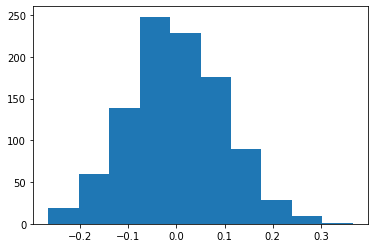

In [41]:
plt.hist(np.random.normal(loc=0,scale=0.1,size=1000))